In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model


In [6]:
# Fungsi untuk mengonversi warna dari HEX ke RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# Fungsi untuk mengonversi warna dari RGB ke HEX
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % tuple(rgb)

# Fungsi untuk ekstraksi warna kulit rata-rata
def extract_average_face_color(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Gambar tidak ditemukan atau format tidak didukung.")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        raise ValueError("Tidak ada wajah yang terdeteksi dalam gambar.")

    x, y, w, h = faces[0]
    face_region = image[y:y+h, x:x+w]
    face_tensor = tf.convert_to_tensor(face_region, dtype=tf.float32)
    mean_color = tf.reduce_mean(face_tensor, axis=[0, 1])
    mean_color = mean_color.numpy().astype(int)
    hex_color = "#{:02x}{:02x}{:02x}".format(mean_color[2], mean_color[1], mean_color[0])

    return hex_color



In [7]:
# Muat model yang sudah disimpan
model = load_model('pallete_generator.h5')

# Prediksi palet warna berdasarkan warna kulit
def predict_palette(image_path):
    skin_tone_hex = extract_average_face_color(image_path)
    skin_tone_rgb = np.array([hex_to_rgb(skin_tone_hex)])

    predicted_palette = model.predict(skin_tone_rgb)
    predicted_palette = predicted_palette.reshape(-1, 3).astype(int)
    predicted_palette_hex = [rgb_to_hex(color) for color in predicted_palette]

    return skin_tone_hex, predicted_palette_hex

In [8]:
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan palet warna
def display_color_palette(skin_tone_hex, predicted_colors):
    skin_tone_rgb = hex_to_rgb(skin_tone_hex)
    colors = [skin_tone_rgb] + [hex_to_rgb(color) for color in predicted_colors]
    color_labels = ["Extracted Skin Tone"] + [f"Color {i+1}" for i in range(len(predicted_colors))]

    plt.figure(figsize=(12, 2))
    for i, (color, label) in enumerate(zip(colors, color_labels)):
        plt.subplot(1, len(colors), i + 1)
        plt.imshow([[color]])
        plt.title(label, fontsize=8)
        plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 159ms/step


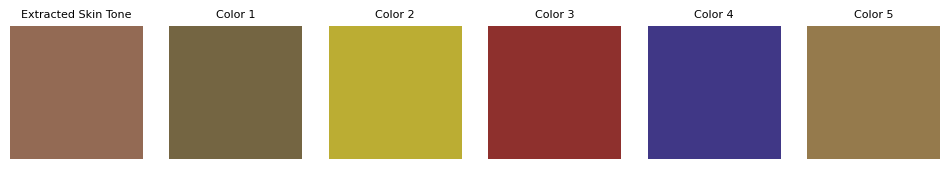

Extracted skin tone: #936a54
Predicted color palette: ['#746542', '#bbad33', '#8e302d', '#403786', '#957a4c']


In [9]:
# Contoh penggunaan
image_path = 'curl.jpeg'
skin_tone_hex, predicted_palette = predict_palette(image_path)
display_color_palette(skin_tone_hex, predicted_palette)
print("Extracted skin tone:", skin_tone_hex)
print("Predicted color palette:", predicted_palette)